In [1]:
"""
Analysis/interpretation of the Random Forest Classifier trained for detection of Hyperpartisan News.
(SemEval2019 Task on "Hyperpartisan News Detection")
"""
CLASSIFIER_PATH  = '../classifiers/RF_by-article_stats-and-counts.pickle'
DOC_ENCODER_PATH = '../generated_datasets/DocEncoder_by-article_stats-and-counts.pickle'
DATASET_PATH     = '../generated_datasets/by-article_stats-and-counts.npz'

In [2]:
import pickle
import numpy as np

rf_clf = pickle.load(open(CLASSIFIER_PATH, 'rb'))  ## Random Forest Classifier

In [3]:
## Analyze Dataset
dataset = np.load(DATASET_PATH)
X, y = dataset['X'], dataset['y']

In [4]:
import os, sys

sys.path.insert(1, os.path.join(sys.path[0], '../src'))
import document_encoder

encoder = pickle.load(open(DOC_ENCODER_PATH, 'rb'))
counter = encoder.counter  ## CountVectorizer

In [5]:
## Invert word->idx mapping to get features' names
idx_to_word = {idx: '"{}"'.format(word) for word, idx in counter.vocabulary_.items()}
word_feature_names = [idx_to_word[i] for i in sorted(idx_to_word.keys())]

In [6]:
statistical_feature_names = [
    'num_sentences',       ## Number of sentences
    'avg_sent_word_len',   ## Average sentence length in words
    'avg_sent_char_len',   ## Average sentence length in chars
    'var_sent_char_len',   ## Variance of sentence length in chars
    'avg_word_len',        ## Average word length
    'var_word_len',        ## Variance of word length
    'punct_freq',          ## Frequency of punctuation
    'capital_freq',        ## Frequency of capital letters
    'types_atoms_ratio'    ## Types to atoms ratio
]

In [7]:
feature_names = statistical_feature_names + word_feature_names

In [8]:
## Classifier Feature Importances
rf_clf.feature_importances_

array([0.07098779, 0.03089282, 0.03175361, 0.03549271, 0.03012492,
       0.03813169, 0.03928453, 0.0453966 , 0.04400098, 0.02051239,
       0.03893597, 0.00742571, 0.01225441, 0.00461132, 0.01265352,
       0.00978777, 0.00850962, 0.00760899, 0.00943164, 0.00852886,
       0.00765101, 0.00630694, 0.00381572, 0.00464075, 0.01347229,
       0.00917908, 0.00669274, 0.00522424, 0.01901321, 0.0104065 ,
       0.01493992, 0.02267638, 0.00512259, 0.00948857, 0.00877956,
       0.01144004, 0.01083058, 0.0115706 , 0.00659671, 0.01233621,
       0.00641018, 0.03302811, 0.03064863, 0.01109274, 0.00887792,
       0.01149064, 0.01460757, 0.01150031, 0.0067093 , 0.01234446,
       0.01576297, 0.00787356, 0.00808254, 0.0355903 , 0.03026035,
       0.01584296, 0.00913141, 0.01011466, 0.01412192])

In [9]:
## Post-pruning DT: https://stackoverflow.com/questions/49428469/pruning-decision-trees
from sklearn.tree._tree import TREE_LEAF

def prune_tree(tree, prune_pred):
    prune_at_index(tree, 0, prune_pred)

def prune_at_index(inner_tree, index, prune_pred):
    if prune_pred(inner_tree.value[index]):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_at_index(inner_tree, inner_tree.children_left[index], prune_pred)
        prune_at_index(inner_tree, inner_tree.children_right[index], prune_pred)

In [10]:
## Performance of each of the RF's estimators
estimator_scores = [est.score(X, y) for est in rf_clf.estimators_]
best_estimator_idx = np.argmax(estimator_scores) ## Best individual estimator

In [11]:
from sklearn import tree
import random

dt = rf_clf[best_estimator_idx]

## Aggressive pruning so the tree's visualization is not gigantic...
#prune_tree(dt.tree_, lambda counts: ((counts.min() / counts.sum()) < 0.3) or (counts.min() < 10))
#prune_tree(dt.tree_, lambda counts: (counts.min() / counts.sum()) < 0.3)

In [12]:
"""
from sklearn import tree
from graphviz import Source
import random

graph = Source(
    tree.export_graphviz(
        dt, out_file=None, feature_names=feature_names,
        label='root', class_names=['Mainstream', 'Hyperpartisan'], ## Double-checked labels, seem correct
        #impurity=False, filled=True,
        #max_depth=10
))
## 1 (true) means 'Hyperpartisan'; 0 (false) means 'Mainstream'

graph.format = 'png'
graph.render('hyp_news_dt_by-article', view=False)
#graph
"""

"\nfrom sklearn import tree\nfrom graphviz import Source\nimport random\n\ngraph = Source(\n    tree.export_graphviz(\n        dt, out_file=None, feature_names=feature_names,\n        label='root', class_names=['Mainstream', 'Hyperpartisan'], ## Double-checked labels, seem correct\n        #impurity=False, filled=True,\n        #max_depth=10\n))\n## 1 (true) means 'Hyperpartisan'; 0 (false) means 'Mainstream'\n\ngraph.format = 'png'\ngraph.render('hyp_news_dt_by-article', view=False)\n#graph\n"

In [13]:
def get_decision_path(indicator, n_nodes_ptr, estimator_idx):
    """
    Returns matrix where 1-valued entries indicate the sample goes through the node at that index.
    """
    return indicator[:, n_nodes_ptr[estimator_idx]: n_nodes_ptr[estimator_idx+1]].todense()

In [14]:
def get_vote_counts(rf, sample):
    votes = {0: 0, 1: 0}
    for est in rf_clf.estimators_:
        votes[np.asscalar(est.predict(sample_input))] += 1
    return votes

In [15]:
def print_decision_path(dt, X, sample_idx):
    """
    Prints decision path for the given X[sample_idx] on
     the given decision tree.
    """
    node_indicator = dt.decision_path(X)
    leave_id = dt.apply(X)

    node_index = node_indicator.indices[
                    node_indicator.indptr[sample_idx]:
                    node_indicator.indptr[sample_idx + 1]]

    feature = dt.tree_.feature
    threshold = dt.tree_.threshold

    print('Rules used to predict sample %s: ' % sample_idx)
    for node_id in node_index:
        if leave_id[sample_idx] == node_id:
            continue

        if (X[sample_idx, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("decision id node %s :\t(X[%s, %s] (= %s) %s %s)"
              % (node_id,
                 sample_idx,
                 feature[node_id],
                 X[sample_idx, feature[node_id]],
                 threshold_sign,
                 threshold[node_id]))

In [16]:
sample_idx = 1
print('Predicted:', rf_clf.predict(X[sample_idx:sample_idx+1, :]), end='\n\n')
print_decision_path(dt, X, sample_idx)

Predicted: [1.]

Rules used to predict sample 1: 
decision id node 0 :	(X[1, 53] (= 0.0) <= 0.5)
decision id node 1 :	(X[1, 35] (= 0.0) <= 0.5)
decision id node 2 :	(X[1, 24] (= 0.0) <= 0.5)
decision id node 3 :	(X[1, 57] (= 0.0) <= 2.0)
decision id node 4 :	(X[1, 7] (= 0.05253012105822563) > 0.024064072407782078)
decision id node 10 :	(X[1, 27] (= 4.0) > 3.5)


In [17]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from collections import defaultdict

def compute_feature_importances(clf, X, y, n_splits=10):

    impurity_dec = np.zeros((X.shape[1])) ## Mean impurity decrease
    acc_dec = defaultdict(list) ## Mean accuracy decrease
    
    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5)
    
    ## Cross-validate per-feature scores of mean accuracy decrease
    for train_idx, test_idx in splitter.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        impurity_dec = np.add(impurity_dec, clf.feature_importances_)
        
        for i in range(X.shape[1]): ## For each feature
            X_t = X_test.copy()
            np.random.shuffle(X_t[:, i])
            shuff_acc = accuracy_score(y_test, clf.predict(X_t))
            acc_dec[i].append((acc - shuff_acc) / acc)
            
    impurity_dec = impurity_dec / n_splits
    return acc_dec, impurity_dec

In [18]:
GRAD_BOOST_TREE_PATH = '../classifiers/grid_search_best_GradBoostTree_78.14.pickle'
RAND_FOREST_PATH     = '../classifiers/grid_search_best_RF_77.98.pickle'
gbt_clf = pickle.load(open(GRAD_BOOST_TREE_PATH, 'rb'))  ## Random Forest Classifier
rf_clf  = pickle.load(open(RAND_FOREST_PATH, 'rb'))

In [41]:
N_SPLITS = 200
rf_acc_dec, rf_imp_dec = compute_feature_importances(rf_clf, X, y, n_splits=N_SPLITS)
gbt_acc_dec, gbt_imp_dec = compute_feature_importances(gbt_clf, X, y, n_splits=N_SPLITS)

In [42]:
### Most important features by Mean Impurity Decrease
TOP_N = 10 ## Top-N features to plot

## Importance == Impurity Decrease

#rf_imps = rf_clf.feature_importances_   ## Use final model
#gbt_imps = gbt_clf.feature_importances_

rf_imps = rf_imp_dec                    ## Use cross-validated averages
gbt_imps = gbt_imp_dec

rf_indices = np.argsort(rf_imps)
gbt_indices = np.argsort(gbt_imps)

## Most important features by average feature importance over both classifiers
joined_imps = np.add(rf_imps, gbt_imps) / 2
joined_idxs = np.argsort(joined_imps)[-TOP_N:]

## Most important features by joining top-N features of both classifiers
#joined_idxs = np.intersect1d(rf_indices[-TOP_N:], gbt_indices[-TOP_N:])[::-1]

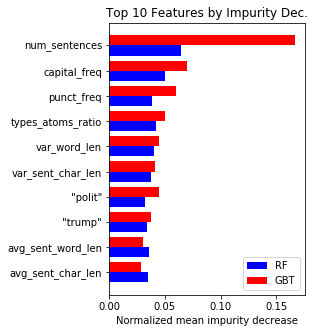

In [43]:
## Plot feature importances (mean impurity decrease)
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()

bar_width = 0.4

yticks = list(range(len(joined_idxs)))

ax.set_title('Top {} Features by Impurity Dec.'.format(TOP_N))
ax.barh([x - bar_width / 2 for x in yticks], rf_imps[joined_idxs], bar_width, color='b', align='center', label='RF')
ax.barh([x + bar_width / 2 for x in yticks], gbt_imps[joined_idxs], bar_width, color='r', align='center', label='GBT')
#ax.barh(yticks, joined_imps[joined_idxs], bar_width, color='g', align='center', label='avg') ## Average of both

plt.yticks(yticks, [feature_names[i] for i in joined_idxs])
ax.set_xlabel('Normalized mean impurity decrease')
ax.legend()

fig.set_size_inches(3.5, 5)
plt.savefig('../imgs/mean_impurity_decrease_top-{}.png'.format(TOP_N), dpi=300, bbox_inches='tight')

In [44]:
def top_k_features(scores, k):
    """
    Computes top-k features (by mean accuracy decrease scores)
    """
    avg_scores = [sum(scores[i]) / len(scores[i]) for i in sorted(scores.keys())]
    
    ## Indices for sorted avg_scores in increasing order
    avg_sc_indices = np.argsort(avg_scores)[-k:] ## Last k features
    return {feature_names[i]: avg_scores[i] for i in avg_sc_indices}

In [45]:
K = 40

top_k_rf = top_k_features(rf_acc_dec, K)
top_k_gbt = top_k_features(gbt_acc_dec, K)

In [46]:
## Average scores over the 2 classifiers
avg_scores = {k: ((top_k_rf[k] + top_k_gbt[k]) / 2) for k in set(top_k_rf.keys()) & set(top_k_gbt.keys())}

In [47]:
import operator

top_n_overall = sorted([(k,v) for k, v in avg_scores.items()], key=operator.itemgetter(1))[-TOP_N:]

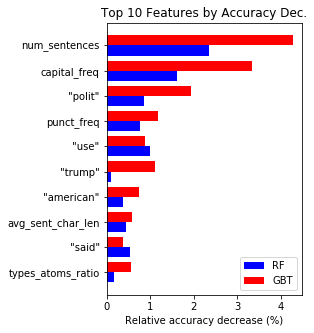

In [48]:
## Plot Mean Accuracy Decrease
fig, ax = plt.subplots()

bar_width = 0.4

yticks = list(range(len(top_n_overall)))

ax.set_title('Top {} Features by Accuracy Dec.'.format(TOP_N))
ax.barh([x - bar_width / 2 for x in yticks], [top_k_rf[k] * 100 for k, v in top_n_overall], bar_width, color='b', align='center', label='RF')
ax.barh([x + bar_width / 2 for x in yticks], [top_k_gbt[k] * 100 for k, v in top_n_overall], bar_width, color='r', align='center', label='GBT')
#ax.barh(yticks, [v * 100 for k, v in top_n_overall], bar_width, color='g', align='center', label='avg') ## Average

plt.yticks(yticks, [k for k,v in top_n_overall])
ax.set_xlabel('Relative accuracy decrease (%)')
ax.legend()

fig.set_size_inches(3.5, 5)
plt.savefig('../imgs/mean_accuracy_decrease_top-{}.png'.format(TOP_N), dpi=300, bbox_inches='tight')